# Production : Text Classification

In [ ]:
!pip install transformers --quiet
!pip install opendatasets --quiet

import opendatasets as od

od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

In [3]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.2 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import os
import time
import copy # For saving best model weights
import torchmetrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use notebook version for better display in Colab
import warnings

# --- Configuration ---
# Data Paths
DATA_PATH = "/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json"

# Model & Tokenizer Settings
PRETRAINED_MODEL_NAME = "google-bert/bert-base-uncased"
MODEL_SAVE_PATH = f"best_sarcasm_bert_model.pth"
MAX_LENGTH = 100 # Max sequence length for tokenizer

# Training Settings
FEATURE_EXTRACT = True # True: Freeze base model, train only classifier. False: Fine-tune (requires more resources)
BATCH_SIZE = 32 # Adjust based on GPU memory
EPOCHS = 15 # Can increase if needed, early stopping is active
LEARNING_RATE = 1e-4 if FEATURE_EXTRACT else 3e-5 # Lower LR for fine-tuning
GRADIENT_CLIP_VALUE = 1.0 # For gradient clipping
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
EARLY_STOPPING_PATIENCE = 3

print(f"Using device: {DEVICE}")
print(f"Using model: {PRETRAINED_MODEL_NAME}")
print(f"Feature Extract Mode: {FEATURE_EXTRACT}")
print(f"Max Sequence Length: {MAX_LENGTH}")

Using device: cuda
Using model: google-bert/bert-base-uncased
Feature Extract Mode: True
Max Sequence Length: 100


## --- 1. Data Loading and Preparation ---

In [5]:
def load_and_split_data(json_path, random_state):
    """Loads JSON data, preprocesses, and splits into train/val/test."""
    try:
        df = pd.read_json(json_path, lines=True)
        # Drop unnecessary column
        if 'article_link' in df.columns:
            df = df.drop(["article_link"], axis=1)
        # Ensure required columns exist
        if 'headline' not in df.columns or 'is_sarcastic' not in df.columns:
            raise ValueError("JSON must contain 'headline' and 'is_sarcastic' fields.")

        # Ensure labels are integers (0 or 1)
        df['label'] = df['is_sarcastic'].astype(int)
        df = df.drop('is_sarcastic', axis=1) # Keep only 'headline' and 'label'

        print(f"Initial data shape: {df.shape}")
        print(f"Class distribution:\n{df['label'].value_counts(normalize=True)}")

        # Split data (Train/Val/Test: 70%/15%/15%)
        train_df, temp_df = train_test_split(
            df,
            test_size=0.3,
            random_state=random_state,
            stratify=df['label']
        )
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.5,
            random_state=random_state,
            stratify=temp_df['label']
        )

        print(f"\nDataset split:")
        print(f"Train: {len(train_df)} samples")
        print(f"Validation: {len(val_df)} samples")
        print(f"Test: {len(test_df)} samples")

        return train_df, val_df, test_df

    except FileNotFoundError:
        raise ValueError(f"Data file not found at {json_path}")
    except Exception as e:
        raise RuntimeError(f"Error during data loading/preparation: {e}")

try:
    train_df, val_df, test_df = load_and_split_data(DATA_PATH, RANDOM_STATE)
    # Binary classification
    NUM_CLASSES = 2 # Sarcastic (1) or Not Sarcastic (0)
except (ValueError, RuntimeError) as e:
    print(e)
    # exit() # Use exit() in a standalone script

Initial data shape: (26709, 2)
Class distribution:
label
0    0.561047
1    0.438953
Name: proportion, dtype: float64

Dataset split:
Train: 18696 samples
Validation: 4006 samples
Test: 4007 samples


## --- 2. Load Tokenizer ---

In [6]:
try:
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
    print("\nTokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    # exit()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


Tokenizer loaded successfully.


## --- 3. Custom PyTorch Dataset (Returns raw text) ---

In [7]:
class SarcasmDataset(Dataset):
    def __init__(self, dataframe):
        self.headlines = dataframe['headline'].tolist()
        # Ensure labels are suitable type (long for CrossEntropy, float for BCE)
        self.labels = dataframe['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return raw text and integer label
        return self.headlines[idx], self.labels[idx]

## --- 4. Custom Collate Function (Tokenizes on-the-fly) ---

In [8]:
def collate_fn(batch):
    """Processes a batch of raw text/labels for BERT input."""
    headlines = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Tokenize the batch of headlines
    # Padding='max_length' ensures all sequences in batch have MAX_LENGTH
    # Truncation=True cuts sequences longer than MAX_LENGTH
    # return_tensors='pt' returns PyTorch tensors
    inputs = tokenizer(
        headlines,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Convert labels to tensor (Float for BCEWithLogitsLoss)
    labels_tensor = torch.tensor(labels, dtype=torch.float32) # Use float for BCE

    # Move tensors to device (can be done here or in training loop)
    # inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    # labels_tensor = labels_tensor.to(DEVICE)

    return inputs, labels_tensor

# --- 5. Create Datasets and DataLoaders ---

In [20]:
train_dataset = SarcasmDataset(train_df)
val_dataset = SarcasmDataset(val_df)
test_dataset = SarcasmDataset(test_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn, # Use custom collate function
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == "cuda" else False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == "cuda" else False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == "cuda" else False
)

print("\nDatasets and DataLoaders created.")


Datasets and DataLoaders created.


## --- 6. Define the Sarcasm Classifier Model ---

In [21]:
!pip install torchinfo

In [22]:
class SarcasmClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_classes, feature_extract):
        super().__init__()
        # Load the base pre-trained model
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        bert_hidden_size = self.bert.config.hidden_size # Get hidden size (e.g., 768)

        # Freeze BERT parameters if doing feature extraction
        if feature_extract:
            print("Freezing base BERT model parameters...")
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
             print("Base BERT model parameters will be fine-tuned...")

        # Custom classifier head
        self.dropout = nn.Dropout(0.3) # Increased dropout slightly
        self.fc1 = nn.Linear(bert_hidden_size, bert_hidden_size // 2) # Example intermediate layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(bert_hidden_size // 2, num_classes) # Output layer (num_classes=1 for binary)

    def forward(self, input_ids, attention_mask):
        # Pass data through BERT base
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        # Use the [CLS] token's output embedding (index 0)
        cls_output = outputs[0][:, 0, :] # Shape: [batch_size, hidden_size]
        # Pass through custom classifier head
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x) # Output raw logits [batch_size, 1] for BCEWithLogitsLoss
        return logits

# Instantiate the model
model = SarcasmClassifier(PRETRAINED_MODEL_NAME, num_classes=1, feature_extract=FEATURE_EXTRACT) # num_classes=1 for binary
model = model.to(DEVICE)
print("\nModel created and moved to device.")

# Optional: Print summary
# try:
#     from torchinfo import summary
#     # Need batch_size for summary, use 1 or BATCH_SIZE
#     # input_data expects dictionary keys matching forward args
#     summary(model, input_data=[
#         torch.zeros((BATCH_SIZE, MAX_LENGTH), dtype=torch.long),
#         torch.zeros((BATCH_SIZE, MAX_LENGTH), dtype=torch.long)
#     ])
# except ImportError:
#     print("\nInstall torchinfo for model summary: pip install torchinfo")
# except Exception as e:
#     print(f"\nCould not print model summary: {e}")

Freezing base BERT model parameters...

Model created and moved to device.


##  --- 7. Loss, Optimizer, Scheduler, Metrics ---

In [23]:
# Use BCEWithLogitsLoss for binary classification with logits output
criterion = nn.BCEWithLogitsLoss()

# Filter parameters to update
params_to_update = model.parameters()
if FEATURE_EXTRACT:
    print("\nParameters being trained:")
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    print("\nAll model parameters will be trained (fine-tuning)...")

optimizer = optim.AdamW(params_to_update, lr=LEARNING_RATE) # AdamW often preferred for transformers
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2) # Schedule based on accuracy

# Use torchmetrics for binary classification accuracy
train_accuracy = torchmetrics.Accuracy(task="binary").to(DEVICE)
val_accuracy = torchmetrics.Accuracy(task="binary").to(DEVICE)


Parameters being trained:
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


## --- 8. Training and Validation Functions ---

In [24]:
def train_one_epoch(model, loader, criterion, optimizer, device, metric, clip_value=None):
    model.train() # Set to training mode
    running_loss = 0.0
    metric.reset()
    num_samples = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for batch_idx, (inputs, labels) in enumerate(pbar):
        # Move batch data to device
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device).unsqueeze(1) # Add dimension for BCEWithLogitsLoss
        current_batch_size = inputs['input_ids'].size(0)
        num_samples += current_batch_size

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask) # Get logits
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()

        # Gradient Clipping
        if clip_value:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        running_loss += loss.item() * current_batch_size
        # Update metric with probabilities (apply sigmoid to logits)
        metric.update(torch.sigmoid(outputs), labels.int())

        # Update progress bar description
        if batch_idx % 50 == 0:
             pbar.set_postfix(loss=f"{loss.item():.4f}")

    # Avoid division by zero
    avg_loss = running_loss / num_samples if num_samples > 0 else 0.0
    epoch_acc = metric.compute()
    return avg_loss, epoch_acc.item()


def validate_one_epoch(model, loader, criterion, device, metric):
    model.eval() # Set to evaluation mode
    running_loss = 0.0
    metric.reset()
    num_samples = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for inputs, labels in pbar:
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            labels = labels.to(device).unsqueeze(1)
            current_batch_size = inputs['input_ids'].size(0)
            num_samples += current_batch_size

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * current_batch_size
            metric.update(torch.sigmoid(outputs), labels.int())

    avg_loss = running_loss / num_samples if num_samples > 0 else 0.0
    epoch_acc = metric.compute()
    return avg_loss, epoch_acc.item()

## --- 9. Main Training Loop ---

In [25]:

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0 # Track best accuracy
best_model_wts = None
patience_counter = 0

print("\nStarting Training...")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE, train_accuracy, clip_value=GRADIENT_CLIP_VALUE
    )
    val_loss, val_acc = validate_one_epoch(
        model, val_loader, criterion, DEVICE, val_accuracy
    )

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_duration:.2f}s] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc) # Step based on validation accuracy

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.4f} -> {val_acc:.4f}). Saving model...")
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, MODEL_SAVE_PATH)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

total_training_time = time.time() - start_time
print(f"\nTraining Finished. Total time: {total_training_time:.2f}s")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Starting Training...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/15 [61.12s] - Train Loss: 0.5086, Train Acc: 0.7604 | Val Loss: 0.3994, Val Acc: 0.8248
Validation accuracy improved (0.0000 -> 0.8248). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/15 [59.07s] - Train Loss: 0.4315, Train Acc: 0.8071 | Val Loss: 0.3621, Val Acc: 0.8432
Validation accuracy improved (0.8248 -> 0.8432). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/15 [60.71s] - Train Loss: 0.4092, Train Acc: 0.8152 | Val Loss: 0.3527, Val Acc: 0.8505
Validation accuracy improved (0.8432 -> 0.8505). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/15 [61.33s] - Train Loss: 0.4040, Train Acc: 0.8172 | Val Loss: 0.3333, Val Acc: 0.8637
Validation accuracy improved (0.8505 -> 0.8637). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/15 [61.87s] - Train Loss: 0.3935, Train Acc: 0.8196 | Val Loss: 0.3297, Val Acc: 0.8545


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 6/15 [61.46s] - Train Loss: 0.3842, Train Acc: 0.8256 | Val Loss: 0.3190, Val Acc: 0.8642
Validation accuracy improved (0.8637 -> 0.8642). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 7/15 [61.25s] - Train Loss: 0.3771, Train Acc: 0.8309 | Val Loss: 0.3165, Val Acc: 0.8657
Validation accuracy improved (0.8642 -> 0.8657). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 8/15 [61.76s] - Train Loss: 0.3764, Train Acc: 0.8301 | Val Loss: 0.3111, Val Acc: 0.8687
Validation accuracy improved (0.8657 -> 0.8687). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 9/15 [59.81s] - Train Loss: 0.3715, Train Acc: 0.8306 | Val Loss: 0.3125, Val Acc: 0.8717
Validation accuracy improved (0.8687 -> 0.8717). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/15 [59.99s] - Train Loss: 0.3689, Train Acc: 0.8342 | Val Loss: 0.3129, Val Acc: 0.8712


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/15 [59.85s] - Train Loss: 0.3646, Train Acc: 0.8365 | Val Loss: 0.3118, Val Acc: 0.8709


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/15 [60.03s] - Train Loss: 0.3616, Train Acc: 0.8381 | Val Loss: 0.3094, Val Acc: 0.8724
Validation accuracy improved (0.8717 -> 0.8724). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/15 [60.30s] - Train Loss: 0.3597, Train Acc: 0.8377 | Val Loss: 0.3048, Val Acc: 0.8739
Validation accuracy improved (0.8724 -> 0.8739). Saving model...


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/15 [60.02s] - Train Loss: 0.3597, Train Acc: 0.8379 | Val Loss: 0.3067, Val Acc: 0.8727


Training:   0%|          | 0/585 [00:00<?, ?it/s]

Validation:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15/15 [59.86s] - Train Loss: 0.3532, Train Acc: 0.8411 | Val Loss: 0.2988, Val Acc: 0.8774
Validation accuracy improved (0.8739 -> 0.8774). Saving model...

Training Finished. Total time: 917.57s
Best Validation Accuracy: 0.8774


## --- 10. Plot Training History ---

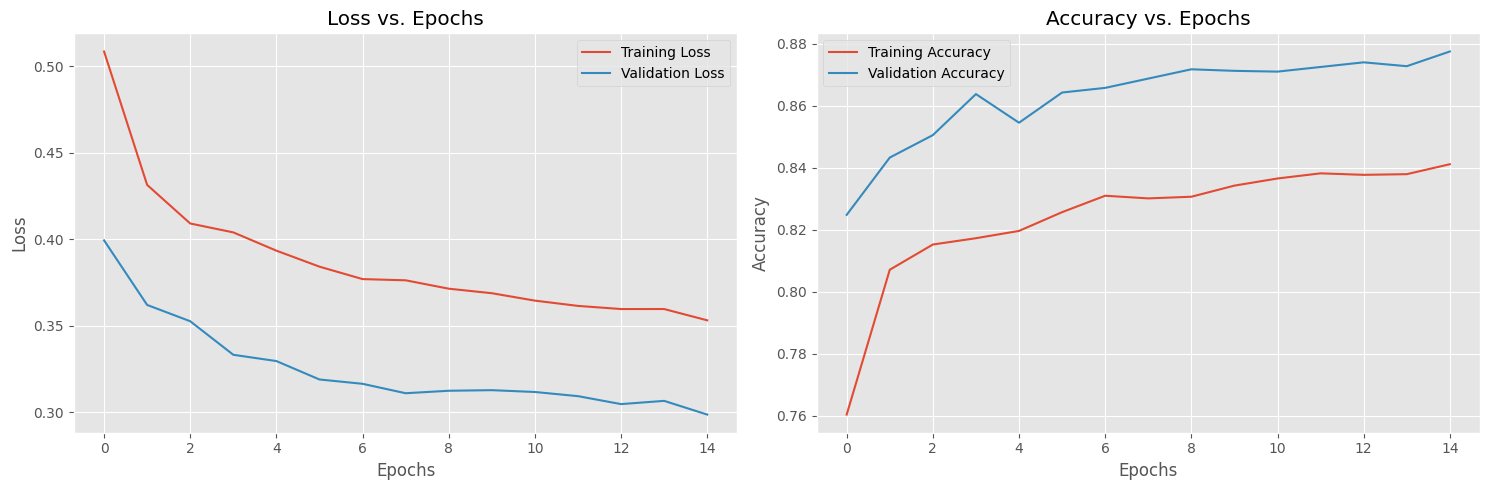

In [26]:

plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history['train_loss'], label='Training Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss vs. Epochs'); axs[0].set_xlabel('Epochs'); axs[0].set_ylabel('Loss'); axs[0].legend()
axs[1].plot(history['train_acc'], label='Training Accuracy')
axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Accuracy vs. Epochs'); axs[1].set_xlabel('Epochs'); axs[1].set_ylabel('Accuracy'); axs[1].legend()
plt.tight_layout(); plt.show()

## --- 11. Final Testing ---

In [28]:

print("\nEvaluating on Test Set using best model weights...")
if best_model_wts:
    model.load_state_dict(best_model_wts)
else:
    print("Warning: No best model weights saved. Loading failed or training didn't improve.")
    # Attempt to load if file exists anyway (maybe from previous run)
    if os.path.exists(MODEL_SAVE_PATH):
       try:
           model.load_state_dict(torch.load(MODEL_SAVE_PATH))
           print("Loaded existing model weights from file.")
       except Exception as e:
           print(f"Could not load existing weights: {e}. Evaluating with final weights.")
    else:
       print("Evaluating with final (potentially untrained/partially trained) weights.")


# Use validation function structure for testing
test_loss, test_acc = validate_one_epoch(model, test_loader, criterion, DEVICE, val_accuracy) # Reuse metric object
print(f"\nFinal Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")

# Detailed classification report
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        input_ids = inputs['input_ids'].to(DEVICE)
        attention_mask = inputs['attention_mask'].to(DEVICE)
        labels_cpu = labels.numpy() # Keep labels on CPU for report

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Apply sigmoid to logits and threshold at 0.5 for predictions
        preds = torch.sigmoid(outputs).round().squeeze().cpu().numpy().astype(int)

        all_preds.extend(preds)
        all_labels.extend(labels_cpu)

if all_preds and all_labels:
    try:
        print("\nClassification Report (Test Set):")
        # Ensure target_names match the binary labels 0 and 1
        print(classification_report(all_labels, all_preds, target_names=['Not Sarcastic', 'Sarcastic']))
    except Exception as e:
        print(f"Could not generate classification report: {e}")
        print("Ensure labels and predictions are correctly formatted.")
else:
    print("No predictions made on test set, skipping classification report.")


Evaluating on Test Set using best model weights...


Validation:   0%|          | 0/126 [00:00<?, ?it/s]


Final Test Loss: 0.3023, Final Test Accuracy: 0.8732

Classification Report (Test Set):
               precision    recall  f1-score   support

Not Sarcastic       0.87      0.90      0.89      2248
    Sarcastic       0.87      0.83      0.85      1759

     accuracy                           0.87      4007
    macro avg       0.87      0.87      0.87      4007
 weighted avg       0.87      0.87      0.87      4007



## --- 12. Inference Function ---

In [29]:
def predict_sarcasm(headline, model_path, tokenizer_name, max_len, device):
    """Loads saved model and tokenizer to predict sarcasm for a new headline."""
    try:
        # Load tokenizer
        inf_tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Load model structure (needs to know num_classes = 1 for binary)
        inf_model = SarcasmClassifier(tokenizer_name, num_classes=1, feature_extract=False) # feature_extract=False doesn't matter for inference loading
        # Load saved weights
        inf_model.load_state_dict(torch.load(model_path, map_location=device))
        inf_model = inf_model.to(device)
        inf_model.eval()

        # Tokenize input headline
        inputs = inf_tokenizer(
            headline,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        # Predict
        with torch.no_grad():
            output_logits = inf_model(input_ids=input_ids, attention_mask=attention_mask)
            probability = torch.sigmoid(output_logits).item() # Get probability
            prediction = 1 if probability > 0.5 else 0 # Threshold

        label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
        return label, probability

    except FileNotFoundError:
        return f"Error: Model file not found at {model_path}.", 0.0
    except Exception as e:
        return f"An error occurred during prediction: {e}", 0.0

# --- Example Inference ---
if os.path.exists(MODEL_SAVE_PATH):
    example_headline = "Nation's Libraries Packed With People Trying To Remember What It's Like To Read"
    predicted_label, confidence_score = predict_sarcasm(
        example_headline,
        MODEL_SAVE_PATH,
        PRETRAINED_MODEL_NAME,
        MAX_LENGTH,
        DEVICE
    )
    print(f"\nInference on: '{example_headline}'")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence (Probability of Sarcasm): {confidence_score:.4f}")

    example_headline_2 = "Scientists Discover New Species Of Bird In Local Park"
    predicted_label_2, confidence_score_2 = predict_sarcasm(
        example_headline_2, MODEL_SAVE_PATH, PRETRAINED_MODEL_NAME, MAX_LENGTH, DEVICE
    )
    print(f"\nInference on: '{example_headline_2}'")
    print(f"Predicted Label: {predicted_label_2}")
    print(f"Confidence (Probability of Sarcasm): {confidence_score_2:.4f}")

else:
    print(f"\nSkipping inference example: Model file not found at {MODEL_SAVE_PATH}")

Base BERT model parameters will be fine-tuned...

Inference on: 'Nation's Libraries Packed With People Trying To Remember What It's Like To Read'
Predicted Label: Sarcastic
Confidence (Probability of Sarcasm): 0.5980
Base BERT model parameters will be fine-tuned...

Inference on: 'Scientists Discover New Species Of Bird In Local Park'
Predicted Label: Sarcastic
Confidence (Probability of Sarcasm): 0.7587
